# Final Project Assignment
# Yihnew Eshetu (yte9pc), Nathan England (nle4bz), and Karyne Williams (kw7me)

In [20]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import *
from pyspark.ml import Pipeline 
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import plotly_express as px

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

## Data Import and Preprocessing

### Function Reads Taxi Zone

In [21]:
def taxiZone():
    taxi = spark.read.csv("/sfs/qumulo/qhome/yte9pc/Project/Yellow_Cab_Data/Taxi_Zone/taxi_zone_lookup.csv", header = True)
    return taxi

### Function Reads Yellow Cab CSVs

In [22]:
def yellowCSVToDF():
    location = "/sfs/qumulo/qhome/yte9pc/Project/Yellow_Cab_Data/"

    files = sorted(glob.glob(location + '*.csv'))

    for idx,f in enumerate(files):
        df = spark.read.csv(f, header = True)
        print(f)

        if idx == 0:
            data = df
        else:
            data = data.union(df)
    return data

### Adds Taxi Zone for Pickup and Dropoff

In [23]:
def yellowTaxiZone():
    # Drop Temp View
    spark.catalog.dropTempView("taxiZone")
    spark.catalog.dropTempView("yellowCab")
    
    taxiZone().createTempView("taxiZone")
    yellowCSVToDF().createTempView("yellowCab")
    yellowCab = spark.sql("SELECT yellowCab.*,\
                     CASE WHEN PU.Borough = 'Bronx'\
                          THEN 1\
                          WHEN PU.Borough = 'Brooklyn'\
                          THEN 2\
                          WHEN PU.Borough = 'EWR'\
                          THEN 3\
                          WHEN PU.Borough = 'Manhattan'\
                          THEN 4\
                          WHEN PU.Borough = 'Queens'\
                          THEN 5\
                          WHEN PU.Borough = 'Staten Island'\
                          THEN 6\
                          ELSE 7\
                     END as PUBorough,\
                     PU.Zone as PUZone,\
                     CASE WHEN PU.service_zone = 'Airports'\
                          THEN 1\
                          WHEN PU.service_zone = 'Boro Zone'\
                          THEN 2\
                          WHEN PU.service_zone = 'EWR'\
                          THEN 3\
                          WHEN PU.service_zone = 'Yellow Zone'\
                          THEN 4\
                          ELSE 5\
                     END as PUService_Zone,\
                     CASE WHEN DO.Borough = 'Bronx'\
                          THEN 1\
                          WHEN DO.Borough = 'Brooklyn'\
                          THEN 2\
                          WHEN DO.Borough = 'EWR'\
                          THEN 3\
                          WHEN DO.Borough = 'Manhattan'\
                          THEN 4\
                          WHEN DO.Borough = 'Queens'\
                          THEN 5\
                          WHEN DO.Borough = 'Staten Island'\
                          THEN 6\
                          ELSE 7\
                     END as DOBorough,\
                     DO.Zone as DOZone,\
                     CASE WHEN DO.service_zone = 'Airports'\
                          THEN 1\
                          WHEN DO.service_zone = 'Boro Zone'\
                          THEN 2\
                          WHEN DO.service_zone = 'EWR'\
                          THEN 3\
                          WHEN DO.service_zone = 'Yellow Zone'\
                          THEN 4\
                          ELSE 5\
                     END as DOService_Zone\
                     FROM yellowCab \
                     INNER JOIN taxiZone PU\
                            ON yellowCab.PULocationID = PU.LocationID \
                     INNER JOIN taxiZone DO\
                            ON yellowCab.DOLocationID = DO.LocationID")
    return yellowCab
data = yellowTaxiZone()

/sfs/qumulo/qhome/yte9pc/Project/Yellow_Cab_Data/yellow_tripdata_2019-05.csv
/sfs/qumulo/qhome/yte9pc/Project/Yellow_Cab_Data/yellow_tripdata_2019-06.csv
/sfs/qumulo/qhome/yte9pc/Project/Yellow_Cab_Data/yellow_tripdata_2019-07.csv
/sfs/qumulo/qhome/yte9pc/Project/Yellow_Cab_Data/yellow_tripdata_2019-08.csv


### Drop duplicates

In [24]:
data = data.dropDuplicates()

### Defining Column Types

In [26]:
data = data.withColumn("VendorID", data["VendorID"].cast(IntegerType()))\
    .withColumn("tpep_pickup_datetime", data["tpep_pickup_datetime"].cast(TimestampType()))\
    .withColumn("tpep_dropoff_datetime", data["tpep_dropoff_datetime"].cast(TimestampType()))\
    .withColumn("passenger_count", data["passenger_count"].cast(IntegerType()))\
    .withColumn("trip_distance", data["trip_distance"].cast(FloatType()))\
    .withColumn("RatecodeID", data["RatecodeID"].cast(IntegerType()))\
    .withColumn("PULocationID", data["PULocationID"].cast(IntegerType()))\
    .withColumn("DOLocationID", data["DOLocationID"].cast(IntegerType()))\
    .withColumn("payment_type", data["payment_type"].cast(IntegerType()))\
    .withColumn("fare_amount", data["fare_amount"].cast(FloatType()))\
    .withColumn("extra", data["extra"].cast(FloatType()))\
    .withColumn("mta_tax", data["mta_tax"].cast(FloatType()))\
    .withColumn("tip_amount", data["tip_amount"].cast(FloatType()))\
    .withColumn("tolls_amount", data["tolls_amount"].cast(FloatType()))\
    .withColumn("improvement_surcharge", data["improvement_surcharge"].cast(FloatType()))\
    .withColumn("total_amount", data["total_amount"].cast(FloatType()))\
    .withColumn("congestion_surcharge", data["congestion_surcharge"].cast(FloatType()))

### Adding Additional Features

In [27]:
data = data.withColumn("pickup_week_day", date_format("tpep_pickup_datetime", "u").cast(IntegerType()))\
    .withColumn("pickup_hour", hour("tpep_pickup_datetime"))\
    .withColumn("dropoff_week_day", date_format("tpep_dropoff_datetime", "u").cast(IntegerType()))\
    .withColumn("dropoff_hour", hour("tpep_dropoff_datetime"))\
    .withColumn("trip_time(mins)", (col("tpep_dropoff_datetime").cast(LongType()) - col("tpep_pickup_datetime").cast(LongType()))/60)\
    .withColumn("distance/time", (col("trip_distance")/col("trip_time(mins)")))
data.select(["tpep_pickup_datetime", "pickup_hour", "pickup_week_day", "tpep_dropoff_datetime", 
             "dropoff_week_day", "dropoff_hour", "trip_time(mins)"]).show(3)

+--------------------+-----------+---------------+---------------------+----------------+------------+---------------+
|tpep_pickup_datetime|pickup_hour|pickup_week_day|tpep_dropoff_datetime|dropoff_week_day|dropoff_hour|trip_time(mins)|
+--------------------+-----------+---------------+---------------------+----------------+------------+---------------+
| 2019-05-01 11:11:23|         11|              3|  2019-05-01 11:40:38|               3|          11|          29.25|
| 2019-05-01 12:34:17|         12|              3|  2019-05-01 13:09:35|               3|          13|           35.3|
| 2019-05-01 16:25:43|         16|              3|  2019-05-01 17:16:46|               3|          17|          51.05|
+--------------------+-----------+---------------+---------------------+----------------+------------+---------------+
only showing top 3 rows



### Drop na

In [45]:
data = data.dropna()

### Print Schema

In [28]:
data.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- improvement_surcharge: float (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- congestion_surcharge: float (nullable = true)
 |-- PUBorough: integer (nullable = false)
 |-- PUZone: string (nullable = true)
 |-- PUService_Zone: integer (nullable = false)
 |-- DOBorough: integer (nullable = false)
 |-- 

### Removing Outliers

Possible Outliers
- tip_amount is null
- tip_amount is negative
- payment_type is null
- negative trip time

### Remove cash and credit card payment where total amount is less than 0

In [46]:
data = data.filter(((data.total_amount >= 0) & (data.payment_type <= 2)) | (data.payment_type > 2))

### Remove rides with trip time less than 0 mins

In [47]:
data = data.filter((col('trip_time(mins)') >= 0) & (col('trip_distance') >= 0))

## Exploratory Data Analysis

### Histogram of Tip Amount

Text(0.5, 0, 'Tip Amount')

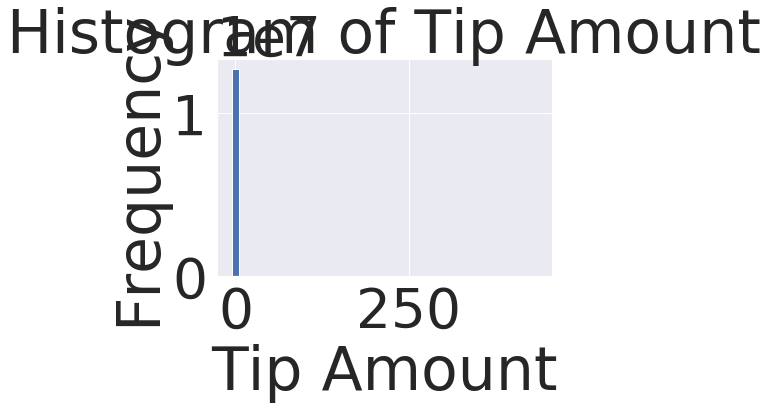

In [59]:
tip_amount = data.filter(data.payment_type == 1)
hists = tip_amount.select('tip_amount').rdd.flatMap(lambda row: row).histogram(5)
data_hist = {
    'bins': hists[0][:-1],
    'freq': hists[1]
    }
plt.bar(data_hist['bins'], data_hist['freq'], width=10)
plt.title('Histogram of ' + 'Tip Amount')
plt.ylabel('Frequency')
plt.xlabel('Tip Amount')

### Correlation Matrix

In [ ]:
df_corr = tip_amount.select(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'trip_time(mins)', 'distance/time'])
assembler = VectorAssembler(inputCols=[col for col in df_corr.columns], outputCol="features")
dt = assembler.transform(df_corr)
tip_amount_corr = Correlation.corr(dt, "features").head()
corr = spark.createDataFrame(tip_amount_corr[0].toArray().tolist(), dt.columns[:-1])
corr = corr.toPandas()
corr['labels'] = dt.columns[:-1]
corr.set_index('labels', inplace = True)

In [ ]:
fig, ax = plt.subplots(figsize=(50,50)) 
sns.set(font_scale=5)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt=".1f",
    annot_kws={'size':18}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
sns.set(font_scale=5)

## We will construct a model to determine the tip amount of a taxis ride. 
What factors effect the amount of tip a passenger gives a driver? 

### Bench Mark Model - Linear

In [ ]:
tip_amount = data.filter(data.payment_type == 1)

In [ ]:
bench_mark_features = ['trip_distance', 'tolls_amount']
bench_mark_data = tip_amount.select(col("tip_amount").alias("label"), *bench_mark_features)
bench_mark_data.printSchema()

In [ ]:
(training, test) = bench_mark_data.randomSplit([.8, .2])

#### Pipeline for bench mark model

In [ ]:
# Configure an ML pipeline, which consists of tree stages: vectorAssembler, standardScaler, and lr
vectorAssembler = VectorAssembler(inputCols=bench_mark_features, outputCol="unscaled_features")
standardScaler = StandardScaler(inputCol="unscaled_features", outputCol="features")
lr = LinearRegression(maxIter=10, regParam=.01)
stages = [vectorAssembler, standardScaler, lr]
pipeline = Pipeline(stages=stages)

In [ ]:
model = pipeline.fit(training)
prediction = model.transform(test)

#### Model Evaluation

In [ ]:
eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
# Mean Square Error
mse = eval.evaluate(prediction, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

# r2 - coefficient of determination
r2 = eval.evaluate(prediction, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

adjr2 = 1 -(((1-r2)*(test.count()-1))/(test.count()-(len(test.columns)-1)-1))
print("adjr2: %.3f" %adjr2)

### Champion Models

#### Bench Mark Model - Linear with Model Selection and Tuning
10 Fold Cross Validation and parameter tuning

##### Pipeline

In [ ]:
# Configure an ML pipeline, which consists of tree stages: vectorAssembler, standardScaler, and lr
#vectorAssembler = VectorAssembler(inputCols=bench_mark_features, outputCol="unscaled_features")
#standardScaler = StandardScaler(inputCol="unscaled_features", outputCol="features")
lr = LinearRegression(maxIter=10)
stages = [vectorAssembler, standardScaler, lr]
pipeline = Pipeline(stages=stages)

# Elastic net parameter α set to 1, it is equivalent to a Lasso model. 
# if α is set to 0, the trained model reduces to a ridge regression model. 
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [.01, 0.1, 0.3, 0.6]) \
    .addGrid(lr.elasticNetParam, [0, 0.3, 0.6, 1]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=10)  # use 10 folds

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(training)

In [ ]:
# Make predictions on test data. model is the model with combination of parameters that performed best.
prediction_tuning = cvModel.transform(test)

In [ ]:
eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
# Mean Square Error
mse = eval.evaluate(prediction_tuning, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

# r2 - coefficient of determination
r2 = eval.evaluate(prediction_tuning, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

adjr2 = 1 -(((1-r2)*(test.count()-1))/(test.count()-(len(test.columns)-1)-1))
print("adjr2: %.3f" %adjr2)

In [ ]:
cvModel.getEstimatorParamMaps()

In [ ]:
cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)]